In [25]:
import pandas as pd
from patsy import dmatrices
import matplotlib.pyplot as plt
import math as m
import numpy as np
import seaborn as sns
import statsmodels as sm
import statsmodels.api as sma
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
sns.set()

In [26]:
def growth_rate_to_doubling_time(growth_rates):
    return np.sign(growth_rates) * (np.log(2) / (np.sign(growth_rates) * growth_rates))

def doubling_time_to_growth_rate(doubling_times):
    return np.sign(doubling_times) * ( np.log(2) / (np.sign(doubling_times) * doubling_times))

In [27]:
data = pd.read_excel("../../Data/simulation_results_no_tracing_adherence.xlsx", index_col = 0)
days_simulated = 25

In [28]:
data

,hazard_rate_scale,infection_reporting_prob,contact_tracing_success_prob,contact_trace_delay_par,reduce_contacts_by,two_step_tracing,prob_has_trace_app,hh_prob_will_take_up_isolation,prob_household_prop_not_adhere,prob_not_adhere,...,15,16,17,18,19,20,21,22,23,24
0,0.243986,0.5,0.781792,1.816581,0.107342,True,0.372344,0.700958,0.445415,0.024503,...,85636,100335,116509,134903,155602,178887,205142,234476,267955,304963
1,0.229609,0.3,0.736520,2.003565,0.610391,False,0.475622,0.612207,0.283846,0.024230,...,25747,27633,29606,31589,33591,35513,37449,39459,41440,43337
2,0.229609,0.3,0.767101,1.554755,0.152562,False,0.240969,0.689166,0.285538,0.031503,...,83454,98383,115817,135395,157559,182654,211559,244414,282055,324542
3,0.222421,0.2,0.832797,2.296827,0.333543,True,0.299735,0.846651,0.280449,0.034114,...,54834,62896,72000,82046,93113,105307,118405,132928,148867,166369
4,0.222421,0.2,0.798164,1.635507,0.319361,False,0.493665,0.704698,0.458960,0.033643,...,56630,64942,74051,83859,94953,107285,120405,134695,150682,168074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.222421,0.2,0.805386,1.988478,0.126283,False,0.065854,0.809741,0.439301,0.038156,...,89515,107058,127855,152272,180664,214019,252905,297871,349996,410790
96,0.222421,0.2,0.780039,2.149842,0.187652,False,0.226714,0.858722,0.264979,0.018614,...,80710,95661,112614,132187,155086,181338,210985,245344,284722,329982
97,0.222421,0.2,0.863291,2.165776,0.652100,False,0.474276,0.624638,0.453327,0.044614,...,23184,24837,26499,28157,29795,31386,33009,34545,36182,37699
98,0.229609,0.3,0.866159,2.489484,0.036391,False,0.147626,0.781187,0.334440,0.012799,...,114103,138277,166806,201093,241381,288750,343984,408638,484256,573060


In [29]:
infection_counts = [str(i) for i in range(days_simulated)]
infection_counts = data[infection_counts]

Text(0.5, 1.0, 'Total Infected')

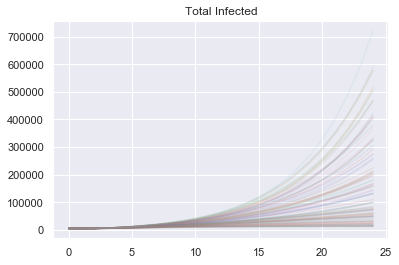

In [30]:
for _ in range(data.shape[0]):
    plt.plot(range(days_simulated), infection_counts.iloc[_], alpha = 0.1)
plt.title("Total Infected")

Text(0.5, 1.0, '$log_2$(Total Infected)')

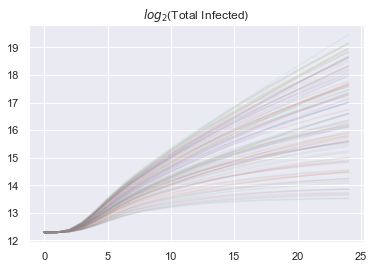

In [31]:
for _ in range(data.shape[0]):
    plt.plot(range(days_simulated), infection_counts.iloc[_].apply(lambda x: np.log2(x)), alpha = 0.1)
plt.title("$log_2$(Total Infected)")

Text(0.5, 1.0, 'Infection Incidence')

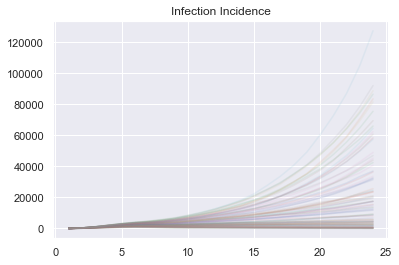

In [32]:
for _ in range(data.shape[0]):
    plt.plot(range(days_simulated), infection_counts.iloc[_].diff(1), alpha = 0.1)
plt.title("Infection Incidence")

Text(0.5, 1.0, 'Infection Incidence (10 epidemics)')

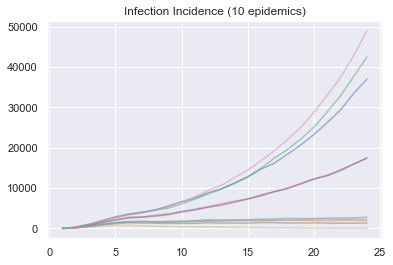

In [33]:
for _ in range(10):
    plt.plot(range(days_simulated), infection_counts.iloc[_].diff(1), alpha = 0.5)
plt.title("Infection Incidence (10 epidemics)")

Text(0.5, 1.0, '$Log_e$(Case Incidence) (14 epidemics)')

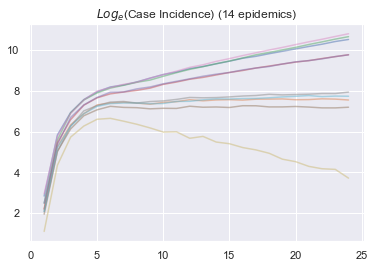

In [34]:
for _ in range(10):
    plt.plot(range(days_simulated), infection_counts.iloc[_].diff(1).apply(lambda x: np.log(x)), alpha = 0.5)
plt.title("$Log_e$(Case Incidence) (14 epidemics)")

We can see the variance begins to increase for the exponentially decaying epidemcis as they near 0. In order to get good estimation for the epidemics, we icnrease the starting number of infections. In this experiment, we start with 5000 infected, let the process run for 10 days, and then estimated the growth rate using days 10-30.

In [35]:
log_diff = infection_counts.iloc[_].diff(1).apply(lambda x: np.log(x))

data_set_up = {
    "log_case_incidence": log_diff[10:days_simulated],
    "time": list(range(10, days_simulated))
}
dataframe = pd.DataFrame(data_set_up)

OLS Regression Results                            
Dep. Variable:     log_case_incidence   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     102.9
Date:                Sat, 20 Jun 2020   Prob (F-statistic):           1.52e-07
Time:                        16:33:01   Log-Likelihood:                 28.314
No. Observations:                  15   AIC:                            -52.63
Df Residuals:                      13   BIC:                            -51.21
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.2193      0.041    174.977      0.000       7.130       7.308
t

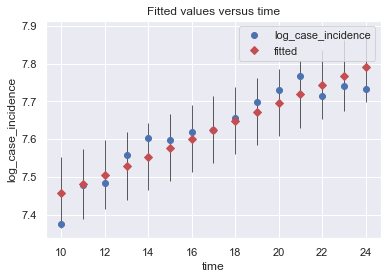

In [36]:
y, X = dmatrices('log_case_incidence ~ time', 
                 data = dataframe)
model = sma.OLS(y, X)
res = model.fit()
print(res.summary())
fig = sm.graphics.regressionplots.plot_fit(res, 1)
print(f"doublign time = {m.log(2)/res.params[1]}")

In [37]:
data_subset = infection_counts

In [38]:
growth_rates = []
doubling_times = []
for _ in range(data_subset.shape[0]):
    print(f"current fit; {_}", end = "\r")
    
    log_diff = data_subset.iloc[_].diff(1).apply(lambda x: np.log(x))

    data_set_up = {
        "log_case_incidence": log_diff[10:25],
        "time": list(range(10, 25))
    }
    dataframe = pd.DataFrame(data_set_up)
    dataframe = pd.DataFrame(data_set_up)
    
    y, X = dmatrices('log_case_incidence ~ time', 
                     data = dataframe)
    model = sma.RLM(y, X)
    res = model.fit()
    growth_rates.append(res.params[1])

    if res.params[1] == -float("inf"):
        print(f"missing data in line {_}")

current fit; 99

In [39]:
x = pd.Series(growth_rates) # 200 values
#x = x[x.between(x.quantile(.05), x.quantile(.95))] # without outliers

Text(0.5, 1.0, 'Distribution of Growth Rates')

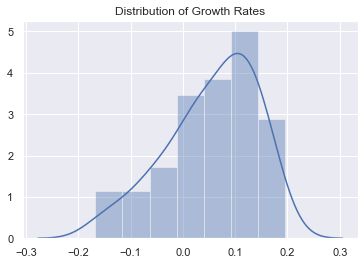

In [40]:
sns.distplot(x)
plt.title("Distribution of Growth Rates")

In [41]:
data_pars = data[data.columns[0:10]]
growth_rate_series = pd.Series(growth_rates)
data_pars["growth_rate"] = growth_rate_series

In [42]:
data_pars

,hazard_rate_scale,infection_reporting_prob,contact_tracing_success_prob,contact_trace_delay_par,reduce_contacts_by,two_step_tracing,prob_has_trace_app,hh_prob_will_take_up_isolation,prob_household_prop_not_adhere,prob_not_adhere,growth_rate
0,0.243986,0.5,0.781792,1.816581,0.107342,True,0.372344,0.700958,0.445415,0.024503,0.122151
1,0.229609,0.3,0.736520,2.003565,0.610391,False,0.475622,0.612207,0.283846,0.024230,0.007472
2,0.229609,0.3,0.767101,1.554755,0.152562,False,0.240969,0.689166,0.285538,0.031503,0.135489
3,0.222421,0.2,0.832797,2.296827,0.333543,True,0.299735,0.846651,0.280449,0.034114,0.103513
4,0.222421,0.2,0.798164,1.635507,0.319361,False,0.493665,0.704698,0.458960,0.033643,0.099842
...,...,...,...,...,...,...,...,...,...,...,...
95,0.222421,0.2,0.805386,1.988478,0.126283,False,0.065854,0.809741,0.439301,0.038156,0.159650
96,0.222421,0.2,0.780039,2.149842,0.187652,False,0.226714,0.858722,0.264979,0.018614,0.143918
97,0.222421,0.2,0.863291,2.165776,0.652100,False,0.474276,0.624638,0.453327,0.044614,0.001630
98,0.229609,0.3,0.866159,2.489484,0.036391,False,0.147626,0.781187,0.334440,0.012799,0.169174


OLS Regression Results                            
Dep. Variable:            growth_rate   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     2305.
Date:                Sat, 20 Jun 2020   Prob (F-statistic):          2.39e-102
Time:                        16:33:03   Log-Likelihood:                 375.61
No. Observations:                 100   AIC:                            -731.2
Df Residuals:                      90   BIC:                            -705.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.272

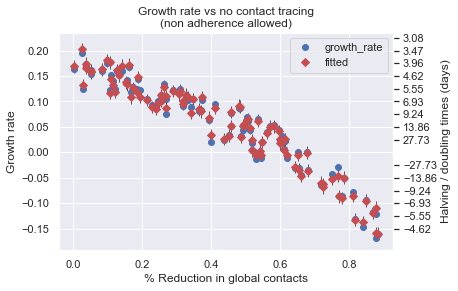

In [43]:
y, X = dmatrices('growth_rate ~ reduce_contacts_by + I(reduce_contacts_by**2) + I(reduce_contacts_by**3) + I(prob_has_trace_app**2) + contact_tracing_success_prob + contact_trace_delay_par + infection_reporting_prob + hh_prob_will_take_up_isolation + prob_not_adhere', 
                 data = data_pars)
model_2 = sma.OLS(y, X)
res = model_2.fit()
print(res.summary())

fig, ax = plt.subplots()

plot = sm.graphics.regressionplots.plot_fit(res, "reduce_contacts_by", ax = ax)

y_vals = np.linspace(-0.15, 0.25, 17)
y_vals = np.concatenate((y_vals[:6], y_vals[7:]))

ax2 = ax.secondary_yaxis("right",
                         functions=(growth_rate_to_doubling_time,
                                    doubling_time_to_growth_rate))
ax2.set_ticks(growth_rate_to_doubling_time(y_vals), minor = False)

plt.ylabel("Growth rate")
plt.xlabel("% Reduction in global contacts")
plt.title("Growth rate vs no contact tracing\n(non adherence allowed)")
ax2.set_ylabel("Halving / doubling times (days)")

plt.savefig("../../Figures/Simulation - no test delay adherence model/growth_rate_global_contacts.svg", bbox_inches = 'tight')
plt.savefig("../../Figures/Simulation - no test delay adherence model/growth_rate_global_contacts.png", bbox_inches = 'tight')

## Residuals vs Fitted Value

There doesn't appear to be any systematic deviation from our predicted value

Text(0, 0.5, 'Residual')

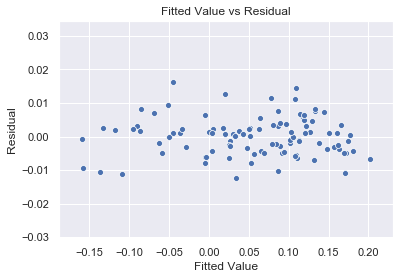

In [44]:
sns.scatterplot(res.fittedvalues, res.resid)
plt.title("Fitted Value vs Residual")
plt.xlabel("Fitted Value")
plt.ylabel("Residual")

## Residual Distribution

Text(0.5, 1.0, 'Distribution of the residuals')

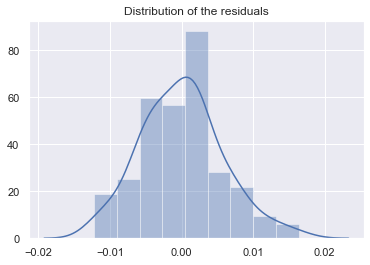

In [45]:
sns.distplot(res.resid)
plt.title("Distribution of the residuals")

## Comparison to reference curve

In [46]:
reference_coefs = pd.read_excel("../../Data/Reference/OLS_coefficients.xlsx", index_col = 0)
reference_coefs

,intercept,coef_contact_reduction,coef_contact_reduction**2,coef_contact_reduction**2.1
0,0.22251,-0.255676,0.123382,-0.286964


In [47]:
c = reference_coefs["intercept"].loc[0]
beta_0 = reference_coefs["coef_contact_reduction"].loc[0]
beta_1 = reference_coefs["coef_contact_reduction**2"].loc[0]
beta_2 = reference_coefs["coef_contact_reduction**2.1"].loc[0]
x = np.linspace(0, 0.9)
y = c + beta_0*x + beta_1*x**2 + beta_2*x**3

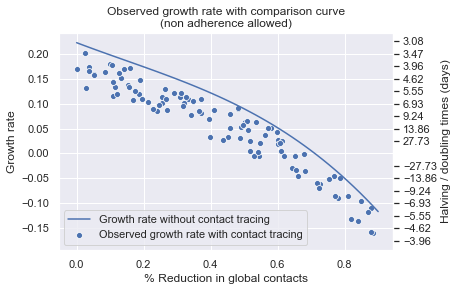

In [48]:
fig, ax = plt.subplots()

y_vals = np.linspace(-0.175, 0.25, 18)
y_vals = np.concatenate((y_vals[:7], y_vals[8:]))

sns.scatterplot(data_pars["reduce_contacts_by"], res.fittedvalues)

plt.plot(x, y)

ax2 = ax.secondary_yaxis("right", functions=(growth_rate_to_doubling_time, doubling_time_to_growth_rate))
ax2.set_ticks(growth_rate_to_doubling_time(y_vals), minor = False)

plt.ylabel("Growth rate")
plt.xlabel("% Reduction in global contacts")
plt.title("Observed growth rate with comparison curve\n(non adherence allowed)")
ax2.set_ylabel("Halving / doubling times (days)")
plt.legend(("Growth rate without contact tracing", "Observed growth rate with contact tracing"))
plt.savefig("../../Figures/Simulation - no test delay adherence model/growth_rate_comparison.svg", bbox_inches = 'tight')
plt.savefig("../../Figures/Simulation - no test delay adherence model/growth_rate_comparison.png", bbox_inches = 'tight')